In [1]:

import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
import argparse
import os
import torch
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
import wandb
import numpy as np
from dataloader import MusicDataset
from model import DVAE 

from midiutil import MIDIFile
from pydub import AudioSegment
from midi2audio import FluidSynth
import matplotlib.pyplot as plt

In [2]:
path = 'config.yaml'

config = OmegaConf.load(path)

In [3]:


dataset = MusicDataset(config.dataset)
dataloader = DataLoader(dataset, 
                        batch_size=config.train.batch_size, 
                        num_workers=config.train.num_workers,
                        pin_memory=True, #important for speed
                        shuffle=False)

model = DVAE(input_dim=config.model.input_dim, 
                    hidden_dim=config.model.hidden_dim,
                    hidden_dim_em=config.model.hidden_dim_em, 
                    hidden_dim_tr=config.model.hidden_dim_tr, 
                    latent_dim=config.model.latent_dim).to('mps')
    
#load weights
ckpt_path = 'saved_models/dvae_model_500.pt'
ckpt = torch.load(ckpt_path, map_location='mps')
model.load_state_dict(ckpt)


<All keys matched successfully>

In [9]:
a  = None

In [12]:
len(a)

TypeError: object of type 'NoneType' has no len()

In [4]:
fs = FluidSynth('default.sf2')

In [5]:
def midi_to_song(data, file_name):
    # Create a MIDI file
    midi_file = MIDIFile(1)  # One track
    track = 0
    time = 0  # Start at the beginning
    midi_file.addTrackName(track, time, "Track")
    midi_file.addTempo(track, time, 120)  # Set the tempo

    # Add notes to the MIDI file
    for chord in data:  # Assuming you're using the first song
        duration = 1  # Duration of each chord, you can change this
        for note in chord:
            midi_file.addNote(track, 0, note, time, duration, 100)  # channel set to 0, volume 100
        time += duration

    # Write the MIDI file to disk
    with open(f"{file_name}.mid", "wb") as output_file:
        midi_file.writeFile(output_file)

    # Synthesize MIDI to WAV using FluidSynth
    # fs = FluidSynth('path_to_soundfont.sf2')
    fs.midi_to_audio(f'{file_name}.mid', f'{file_name}.wav')

    # Convert WAV to MP3
    audio = AudioSegment.from_wav(f'{file_name}.wav')
    audio.export(f'{file_name}.mp3', format='mp3')
    

In [8]:
train_data = dataset.original_data['train']

In [178]:
from einops import rearrange, repeat

In [179]:
def mask_input(encodings, sequence_lengths):
    max_sequence_length = encodings.shape[1]
    range_tensor = repeat(torch.arange(max_sequence_length), 'l -> b l', b=bs).to(sequence_lengths.device)
    mask = range_tensor < rearrange(sequence_lengths, 'b -> b ()')
    mask = mask.to(sequence_lengths.device)
    mask = rearrange(mask, 'b s -> b s ()')
    return encodings * mask

In [341]:
for i, (encodings, sequence_lengths) in enumerate(dataloader):
    encodings = encodings.to('mps')
    sequence_lengths = sequence_lengths.to('mps')
    x_hat, _, _, _, _ = model(encodings)
    break

In [342]:
x_hat = x_hat[0]
x_hat = x_hat[:sequence_lengths[0], :]

encodings = encodings[0]
encodings = encodings[:sequence_lengths[0], :]

#print shapes
print(x_hat.shape)
print(encodings.shape)

torch.Size([129, 88])
torch.Size([129, 88])


In [343]:
def latent_to_midi(latent, threshhold):
    
    latent[np.where(latent > threshhold)] = 1 
    latent[np.where(latent <= threshhold)] = 0
    
    latent[np.where(latent == 1)] = np.where(latent == 1)[1] + 21
    latent = latent.astype(int)
    
    midis = []
    for i in range(latent.shape[0]):
        non_zero = np.nonzero(latent[i])
        midis.append( tuple(latent[i][non_zero]) )
    return midis
        

In [350]:
latent = x_hat.detach().cpu().numpy().copy()

In [351]:
midis = []
for i in range(latent.shape[0]):
    latent[i][np.where(latent[i] > 0.55)] = 1
    latent[i][np.where(latent[i] <= 0.55)] = 0
    

In [352]:
midis = []
for i in range(latent.shape[0]):
    non_zero = np.nonzero(latent[i])
    print(non_zero)
    midis.append( tuple(latent[i][non_zero]) )

(array([19, 21, 37, 57, 64, 72]),)
(array([57, 72]),)
(array([47, 57, 72, 87]),)
(array([57, 72]),)
(array([57, 69]),)
(array([13, 57, 69, 72]),)
(array([57, 72]),)
(array([72]),)
(array([40, 57, 87]),)
(array([47, 72]),)
(array([ 0, 19, 72]),)
(array([], dtype=int64),)
(array([ 0, 57, 82]),)
(array([40, 46, 57, 72]),)
(array([55, 72]),)
(array([69, 72]),)
(array([ 9, 40, 46, 55, 57, 64, 72, 82]),)
(array([19, 57, 72, 87]),)
(array([57, 72, 75, 87]),)
(array([57, 69, 72]),)
(array([57, 72]),)
(array([57, 72]),)
(array([57]),)
(array([37, 57, 69]),)
(array([57]),)
(array([33, 57, 87]),)
(array([57]),)
(array([57]),)
(array([72]),)
(array([40, 55, 57, 72]),)
(array([13, 21, 40, 46, 47, 57, 61, 72, 87]),)
(array([57, 72]),)
(array([], dtype=int64),)
(array([19, 69, 72]),)
(array([47, 72]),)
(array([46, 57, 64, 72, 87]),)
(array([57, 72]),)
(array([], dtype=int64),)
(array([57, 72]),)
(array([57, 72]),)
(array([72]),)
(array([55]),)
(array([57, 69, 72]),)
(array([57, 72]),)
(array([40, 57,

In [329]:
midis

[(1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0),
 (1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0),
 (1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0),
 (1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1

In [244]:
latent[0]

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 1.], dtype=float32)

In [118]:
midis = latent_to_midi(x_hat.detach().cpu().numpy(), .4)
print(midis)

[(21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108), (21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108), (21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 

In [93]:
print(midis_orig)

[(60, 72, 79, 88), (72, 79, 88), (67, 70, 76, 84), (69, 77, 86), (67, 70, 79, 88), (65, 72, 81, 89), (65, 72, 81, 89), (58, 70, 77, 86), (69, 70, 77, 86), (68, 71, 76, 86), (69, 72, 76, 84), (66, 69, 74, 84), (67, 74, 79, 83), (60, 76, 79, 84), (60, 76, 79, 84), (60, 76, 79, 84), (67, 71, 79, 86), (66, 69, 74, 86), (62, 72, 78, 86), (67, 71, 79, 86), (64, 71, 80, 88), (69, 72, 81, 84), (69, 76, 81, 84), (69, 76, 81, 84), (69, 76, 84), (62, 65, 74, 83), (60, 67, 76, 84), (67, 72, 77, 86), (55, 71, 79, 86), (60, 67, 76, 84), (60, 67, 76, 84), (60, 67, 76, 84), (60, 72, 79, 88), (72, 79, 88), (67, 70, 76, 84), (69, 77, 86), (67, 70, 79, 88), (65, 72, 81, 89), (65, 72, 81, 89), (58, 70, 77, 86), (69, 70, 77, 86), (68, 71, 76, 86), (69, 72, 76, 84), (66, 69, 74, 84), (67, 74, 79, 83), (60, 76, 79, 84), (60, 76, 79, 84), (60, 76, 79, 84), (67, 71, 79, 86), (66, 69, 74, 86), (62, 72, 78, 86), (67, 71, 79, 86), (64, 71, 80, 88), (69, 72, 81, 84), (69, 76, 81, 84), (69, 76, 81, 84), (69, 76, 84

In [43]:
midi_to_song(midis, 'original_recon')

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'original_recon.wav'..


In [333]:
original = encodings.detach().cpu().numpy()

In [334]:
# x_hat = x_hat.unsqueeze(0)
x_hat = x_hat.detach().cpu().numpy()
threshhold = .5

In [335]:
x_hat[np.where(x_hat > threshhold)[0]] = 1
x_hat[np.where(x_hat <= threshhold)[0]] = 0

In [173]:
for row, col in zip(rows, cols):
    x_hat[row, col] = col + 21
    

In [147]:
x_hat[np.where(x_hat > threshhold)[1]] = 1 
x_hat[np.where(x_hat <= threshhold)[1]] = 0

rows, cols = np.where(x_hat == 1)

# Replace 1's with column indices
for row, col in zip(rows, cols):
    x_hat[row, col] = col + 21

In [148]:
x_hat

array([[ 21.,  22.,  23., ..., 106., 107., 108.],
       [ 21.,  22.,  23., ..., 106., 107., 108.],
       [ 21.,  22.,  23., ..., 106., 107., 108.],
       ...,
       [ 21.,  22.,  23., ..., 106., 107., 108.],
       [ 21.,  22.,  23., ..., 106., 107., 108.],
       [ 21.,  22.,  23., ..., 106., 107., 108.]], dtype=float32)

In [87]:
rows, cols = np.where(original == 1)

# Replace 1's with column indices
for row, col in zip(rows, cols):
    original[row, col] = col + 21

In [149]:
original.shape[0]

129

In [150]:

midis_orig = []
for i in range(original.shape[0]):
    non_zero = np.nonzero(original[i])
    midis_orig.append( tuple(original[i][non_zero]) )

In [151]:
#convert numbers in midi to int
midis_orig = [tuple(map(int, x)) for x in midis_orig]

In [152]:
midis_orig

[(60, 72, 79, 88),
 (72, 79, 88),
 (67, 70, 76, 84),
 (69, 77, 86),
 (67, 70, 79, 88),
 (65, 72, 81, 89),
 (65, 72, 81, 89),
 (58, 70, 77, 86),
 (69, 70, 77, 86),
 (68, 71, 76, 86),
 (69, 72, 76, 84),
 (66, 69, 74, 84),
 (67, 74, 79, 83),
 (60, 76, 79, 84),
 (60, 76, 79, 84),
 (60, 76, 79, 84),
 (67, 71, 79, 86),
 (66, 69, 74, 86),
 (62, 72, 78, 86),
 (67, 71, 79, 86),
 (64, 71, 80, 88),
 (69, 72, 81, 84),
 (69, 76, 81, 84),
 (69, 76, 81, 84),
 (69, 76, 84),
 (62, 65, 74, 83),
 (60, 67, 76, 84),
 (67, 72, 77, 86),
 (55, 71, 79, 86),
 (60, 67, 76, 84),
 (60, 67, 76, 84),
 (60, 67, 76, 84),
 (60, 72, 79, 88),
 (72, 79, 88),
 (67, 70, 76, 84),
 (69, 77, 86),
 (67, 70, 79, 88),
 (65, 72, 81, 89),
 (65, 72, 81, 89),
 (58, 70, 77, 86),
 (69, 70, 77, 86),
 (68, 71, 76, 86),
 (69, 72, 76, 84),
 (66, 69, 74, 84),
 (67, 74, 79, 83),
 (60, 76, 79, 84),
 (60, 76, 79, 84),
 (60, 76, 79, 84),
 (67, 71, 79, 86),
 (66, 69, 74, 86),
 (62, 72, 78, 86),
 (67, 71, 79, 86),
 (64, 71, 80, 88),
 (69, 72, 81,

In [48]:
midi_to_song(midis, 'original')

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'original.wav'..


In [67]:
z = torch.randn(1, 40, 100).to('mps')
with torch.no_grad():
    x_hat, _, _ = model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().numpy()
    
midis = latent_to_midi(x_hat.copy(), .5)
print(midis)
midi_to_song(midis, 'random')


[(), (), (60, 76, 84), (), (60, 67), (67, 74, 83), (67, 74), (67, 74), (64, 67), (67, 76), (76,), (76, 84), (78,), (69,), (60, 76), (74, 78, 81), (), (60, 76), (), (), (67, 71, 74), (76, 79, 84), (), (84,), (67, 71, 74), (67,), (76,), (67, 74), (), (), (71,), (67,), (74,), (69, 84), (60, 76), (67,), (69, 76), (60, 67, 76), (), (69, 76)]
FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'random.wav'..


In [63]:
x_hat.flatten().shape

(3520,)

(array([1.673e+03, 2.140e+02, 1.560e+02, 1.400e+02, 1.270e+02, 8.400e+01,
        7.700e+01, 7.700e+01, 6.600e+01, 6.100e+01, 5.000e+01, 5.000e+01,
        5.600e+01, 4.400e+01, 4.200e+01, 3.300e+01, 2.800e+01, 3.700e+01,
        3.500e+01, 3.600e+01, 3.200e+01, 2.300e+01, 2.700e+01, 2.000e+01,
        2.600e+01, 1.500e+01, 2.000e+01, 1.700e+01, 1.800e+01, 1.800e+01,
        1.400e+01, 1.200e+01, 1.100e+01, 1.000e+01, 1.900e+01, 1.400e+01,
        8.000e+00, 7.000e+00, 8.000e+00, 6.000e+00, 1.200e+01, 6.000e+00,
        4.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 2.000e+00, 6.000e+00,
        6.000e+00, 7.000e+00, 4.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 5.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+0

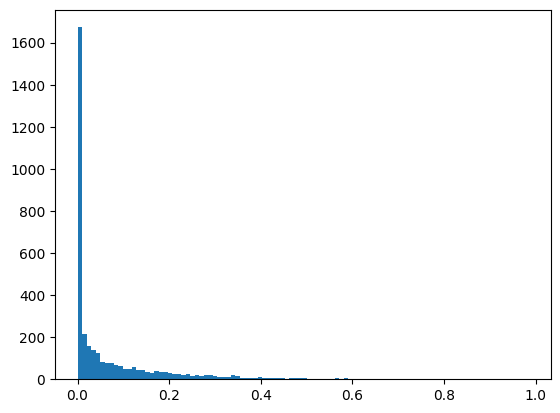

In [66]:
plt.hist(x_hat.flatten(), bins=100)